(289, 399)


(0.0, 22.0)

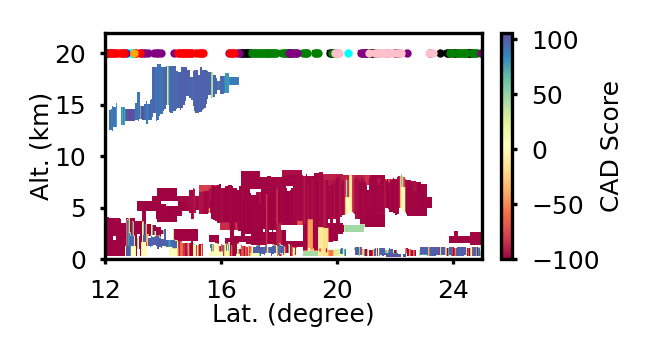

In [64]:
def read_text(fname):
    fo=open(fname,'r') #create file object
    #headstr=fo.readline()
    data=fo.readlines()
    #print (data)
    fo.close()  # close object
    return data

def layer2profile(alt,top,base,data):
    Nh=len(alt)
    Ns=top.shape[0]
    prof_data=np.zeros((Ns,Nh),'f')
    
    for si in range(Ns):
        tptop=top[si,:]
        tpbase=base[si,:]
        tpdata=data[si,:]
        ind=np.where(tptop >0)[0]
        Nlayer=len(ind)
        
        if Nlayer > 0 :
            for hi in range(Nlayer):
                topdiff=abs(tptop[hi]-alt)
                ind=np.where(min(topdiff) == topdiff)[0]
                top_scp=ind[0]
                basediff=abs(tpbase[hi]-alt)
                ind=np.where(min(basediff) == basediff)[0]
                base_scp=ind[0]
                signdata=tpdata[hi]
                prof_data[si,top_scp:base_scp+1]=signdata
    return prof_data


#=== to plot the case used for aerosol paper ===
#=== input need the case in 201907240323, MLay, APRO data
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC


lidaerocld_flag='cloud_aerosol_category_201907240323.txt'
lidfname1='/data/keeling/a/yulanh/c/CALIOP/MLay/2019/CAL_LID_L2_05kmMLay-Standard-V4-20.2019-07-24T03-23-12ZN.hdf'
#lidfname2=dir1+'CAL_LID_L2_05kmAPro-Standard-V4-20.2019-07-24T03-23-12ZN.hdf'


Nh=399
alt=np.zeros(Nh,'f')
alt[0:54]=29.92-np.arange(0,54,1)*0.18
alt[53:253]=20.2-np.arange(0,200,1)*0.06
alt[253:399]=8.2-np.arange(0,146)*0.06

lonrange1=-25
lonrange2=-20
latrange1=12
latrange2=25

# read lidar data
hdf=SD(lidfname1)
lat=hdf.select('Latitude')
lat=lat[:,:]
lon=hdf.select('Longitude')
lon=lon[:,:]
lidtop=hdf.select('Layer_Top_Altitude')
lidtop=lidtop[:,:]
lidbase=hdf.select('Layer_Base_Altitude')
lidbase=lidbase[:,:]
cad=hdf.select('CAD_Score')
cad=cad[:,:]
horizon_res=hdf.select('Horizontal_Averaging')
horizon_res=horizon_res[:,:]


# read cloud-aerosol flag
data=read_text(lidaerocld_flag)
splitcol=data[0].split(' ')
Ncol=len(splitcol)-splitcol.count('')
Nrow=len(data)

dataT=np.zeros((Nrow,Ncol),'i')
for i in range(Nrow):
    splitcol=data[i].split(' ')
    k=0
    for j in range(len(splitcol)):
        if splitcol[j] != '' and splitcol[j] != '\n' :

            dataT[i,k]=float(splitcol[j])
            k=k+1

fontsz=1.0

flagdata=dataT
lon=lon[:,1]
lat=lat[:,1]
ind1=np.where((lon > lonrange1) & (lon < lonrange2))[0]
lon1=lon[ind1]
lat1=lat[ind1]
lidtop1=lidtop[ind1,:]
lidbase1=lidbase[ind1,:]
cad1=cad[ind1,:]
flagdata1=flagdata[ind1,:]

ind2=np.where((lat1 > latrange1) & (lat1 < latrange2))[0]
lon2=lon1[ind2]
lat2=lat1[ind2]
lidtop2=lidtop1[ind2,:]
lidbase2=lidbase1[ind2,:]
cad2=cad1[ind2,:]
flagdata2=flagdata1[ind2,:]
prof_data=layer2profile(alt,lidtop2,lidbase2,cad2)
print(prof_data.shape)

fig,ax =plt.subplots(1,figsize=([2,1]),dpi=300)
img_extent=[min(lat2),max(lat2),min(alt),max(alt)]
prof_data1=prof_data.T
prof_data2=np.flip(prof_data1,1)
prof_data2[prof_data2 ==0]='nan'
f1=ax.imshow(prof_data2,cmap='Spectral',extent=img_extent,aspect='auto')
cbar=plt.colorbar(f1,ticks=[-100,-50,0,50,100],pad=0.04) 
cbar.ax.tick_params(labelsize=6,length=1.2)
cbar.set_label('CAD Score',size=6,labelpad=0.03)

y=np.zeros((len(lat2)),'f')
y=flagdata2[:,0]*20.0
y[y==0]='nan'
p1=ax.plot(lat2,y,color='black',marker='o',markersize=fontsz,mfc='none') #aeroonly

ind=np.where(flagdata2[:,1] == 1)[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='green',marker='o',markersize=fontsz,mfc='none') #mergeonly
    
ind=np.where(flagdata2[:,1] == 2)[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='blue',marker='o',markersize=fontsz,mfc='none') #mergebelowcloud
    
ind=np.where(np.logical_or(flagdata2[:,1] == 3,flagdata2[:,1] ==4))[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='cyan',marker='o',markersize=fontsz,mfc='none') #mergeabovecloud 
    
ind=np.where(np.logical_or(flagdata2[:,1] == 5,flagdata2[:,1] ==6))[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='purple',marker='o',markersize=fontsz,mfc='none') #merge other
    
    
ind=np.where(np.logical_or(flagdata2[:,2] == 1,flagdata2[:,2] ==4,flagdata2[:,2] == 8))[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='red',marker='o',markersize=fontsz,mfc='none') #isolate bc
    
ind=np.where(np.logical_or(flagdata2[:,2] == 2,flagdata2[:,2] ==5,flagdata2[:,2] == 7))[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='pink',marker='o',markersize=fontsz,mfc='none') #isolate bc
    
ind=np.where(np.logical_or(flagdata2[:,2] == 3,flagdata2[:,2] ==6,flagdata2[:,2] == 9))[0]
if (len(ind) > 0):
    y=np.zeros((len(lat2)),'f')
    y[ind]=20.0
    y[y==0]='nan'
    p2=ax.plot(lat2,y,color='orange',marker='o',markersize=fontsz,mfc='none') #isolate bc

ax.set_xticks([12,16,20,24])
ax.set_yticks([0,5,10,15,20])
ax.set_xlabel('Lat. (degree)',size=6,labelpad=0.03)
ax.set_ylabel('Alt. (km)',size=6,labelpad=0.03)
ax.tick_params(labelsize=6,length=1.2)
ax.set_ylim([0,22])


In [40]:
print(y.shape,lat2.shape,flagdata2.shape)
a=np.zeros((3),'f')
a[0:2]=1
print(a)

(289,) (289,) (289, 3)
[1. 1. 0.]
